# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [ ]:
#!pip install -qU ragas==0.2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.7/175.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/1

In [ ]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/davidq/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/davidq/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [1]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [2]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = "IR BENCHMARK"

OpenAI's API Key!

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

In [4]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"data/john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

In [6]:
from langchain_ollama import ChatOllama

# RAGAS was failing with llama3.2 so switched to gpt-4.1-nano
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
# from langchain_ollama import ChatOllama
from langchain_ollama import OllamaEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
# generator_llm = LangchainLLMWrapper(ChatOllama(model="llama3.2"))
generator_embeddings = LangchainEmbeddingsWrapper(OllamaEmbeddings(model="nomic-embed-text"))

In [8]:
from ragas.testset.graph import KnowledgeGraph
from ragas.testset.graph import Node, NodeType
from ragas.testset.transforms import default_transforms, apply_transforms

kg = KnowledgeGraph()
for doc in documents:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )

default_transforms = default_transforms(documents=documents, llm=generator_llm, embedding_model=generator_embeddings)
apply_transforms(kg, default_transforms)

Applying SummaryExtractor:   0%|          | 0/44 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/100 [00:00<?, ?it/s]

Node d1c4e4cd-1585-4a2a-b162-0c47d66de9e4 does not have a summary. Skipping filtering.
Node bf93b286-fea8-433c-9d42-2388defc1382 does not have a summary. Skipping filtering.
Node 7bbb962f-7001-45d3-8a55-6a4636179b14 does not have a summary. Skipping filtering.
Node 04e2a48d-fb1d-44c5-a721-b2a26f513087 does not have a summary. Skipping filtering.
Node b0a74adb-e052-4405-9d93-0c844aeaa5ed does not have a summary. Skipping filtering.
Node be85ec75-f449-4bac-9601-9e21f29a713a does not have a summary. Skipping filtering.
Node aa5f74f3-2855-4370-92eb-568c293c3917 does not have a summary. Skipping filtering.
Node 2c04e509-77ef-49b1-80e5-2d7f5806e171 does not have a summary. Skipping filtering.
Node 354c26f4-4761-4418-a19e-f82c9120b50f does not have a summary. Skipping filtering.
Node 71d546ef-258f-436d-9980-e136e34620a9 does not have a summary. Skipping filtering.
Node 3d32de11-6091-4292-bae3-db46e05dbba5 does not have a summary. Skipping filtering.
Node cfc891ce-1afc-4f65-81a0-68c258826d19 d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/223 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

In [65]:
from ragas.testset import TestsetGenerator
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings, knowledge_graph=kg)
query_distribution = [
    (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.70),
    (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.15),
    (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.15),
]
testset = generator.generate(testset_size=10, query_distribution=query_distribution)

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

In [68]:
testset.to_jsonl("data/testset.jsonl")

## Create LangSmith Dataset

In [66]:
from langsmith import Client

client = Client()

dataset_name = "John Wick Reviews v2"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="John Wick Reviews v2"
)

In [67]:
for data_row in testset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## RAG Chains

### Set Up

In [5]:
from langchain_community.vectorstores import Qdrant
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="nomic-embed-text")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

In [11]:
print(documents[0].metadata)

{'source': 'data/john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 5, 16, 16, 47, 20, 745143)}


In [14]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

In [43]:
# from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI

# chat_model = ChatOllama(model="llama3.2")
chat_model = ChatOpenAI(model="gpt-4.1-nano")

### Naive Retriever

In [44]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

In [45]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

### BM25 Retriever

In [46]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

In [47]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

### Contextual Compression (Using Reranking) Retriever

In [21]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

In [22]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

In [48]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

### Multi-Query Retriever

In [49]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [50]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

### Parent Document Retriever

In [51]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

In [52]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=768, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OllamaEmbeddings(model="nomic-embed-text"), client=client
)

In [53]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

In [29]:
parent_document_retriever.add_documents(documents, ids=None)

In [54]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

### Ensemble Retriever

In [55]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

In [56]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

## IR Benchmark

In [72]:
from ragas import evaluate, RunConfig
from ragas.llms import LangchainLLMWrapper
from langchain_openai import ChatOpenAI
from ragas.metrics import (
    LLMContextRecall,
    Faithfulness,
    FactualCorrectness,
    ResponseRelevancy,
    ContextEntityRecall,
)

evaluator_config = RunConfig(
    timeout=300,          # 5 minutes max for operations
    max_retries=15,       # More retries for rate limits
    max_wait=90,          # Longer wait between retries
    max_workers=8,        # Fewer concurrent API calls
    log_tenacity=True     # Log retry attempts
)
evaluator_metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall()]

llm = ChatOpenAI(model="gpt-4.1-mini")
evaluator_llm = LangchainLLMWrapper(llm)

### Naive RAG

In [71]:
for test_row in testset:
    response = naive_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"].content
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [73]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(testset.to_pandas())

result = evaluate(
    dataset=evaluation_dataset,
    metrics=evaluator_metrics,
    llm=evaluator_llm,
    run_config=evaluator_config
)

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

In [75]:
result

{'context_recall': 0.9242, 'faithfulness': 0.8511, 'factual_correctness(mode=f1)': 0.4755, 'answer_relevancy': 0.8729, 'context_entity_recall': 0.6742}

### BM25 RAG

In [76]:
for test_row in testset:
    response = bm25_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"].content
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [77]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(testset.to_pandas())

result = evaluate(
    dataset=evaluation_dataset,
    metrics=evaluator_metrics,
    llm=evaluator_llm,
    run_config=evaluator_config
)
result

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

{'context_recall': 0.9167, 'faithfulness': 0.6983, 'factual_correctness(mode=f1)': 0.4818, 'answer_relevancy': 0.8768, 'context_entity_recall': 0.5758}

### Contextual Compression (Using Reranking) RAG

In [79]:
import time

for test_row in testset:
    response = contextual_compression_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"].content
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
    time.sleep(10)  # Add 15 second delay between iterations

In [80]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(testset.to_pandas())

result = evaluate(
    dataset=evaluation_dataset,
    metrics=evaluator_metrics,
    llm=evaluator_llm,
    run_config=evaluator_config
)
result

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

{'context_recall': 0.8030, 'faithfulness': 0.7250, 'factual_correctness(mode=f1)': 0.5545, 'answer_relevancy': 0.8789, 'context_entity_recall': 0.7045}

### Multi-Query Retriever RAG

In [81]:
for test_row in testset:
    response = multi_query_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"].content
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [82]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(testset.to_pandas())

result = evaluate(
    dataset=evaluation_dataset,
    metrics=evaluator_metrics,
    llm=evaluator_llm,
    run_config=evaluator_config
)
result

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

{'context_recall': 0.8939, 'faithfulness': 0.9292, 'factual_correctness(mode=f1)': 0.4445, 'answer_relevancy': 0.8732, 'context_entity_recall': 0.6970}

### Parent Document Retriever RAG

In [83]:
for test_row in testset:
    response = parent_document_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"].content
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [84]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(testset.to_pandas())

result = evaluate(
    dataset=evaluation_dataset,
    metrics=evaluator_metrics,
    llm=evaluator_llm,
    run_config=evaluator_config
)
result

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

{'context_recall': 0.0303, 'faithfulness': 0.3833, 'factual_correctness(mode=f1)': 0.2364, 'answer_relevancy': 0.2630, 'context_entity_recall': 0.0000}

### Ensemble Retriever RAG

In [85]:
for test_row in testset:
    response = ensemble_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"].content
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [86]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(testset.to_pandas())

result = evaluate(
    dataset=evaluation_dataset,
    metrics=evaluator_metrics,
    llm=evaluator_llm,
    run_config=evaluator_config
)
result

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

{'context_recall': 1.0000, 'faithfulness': 0.8855, 'factual_correctness(mode=f1)': 0.4518, 'answer_relevancy': 0.8782, 'context_entity_recall': 0.7045}

## RESULTS

In [88]:
NAIVE_RAG = {
  'context_recall': 0.9242, 
  'faithfulness': 0.8511, 
  'factual_correctness(mode=f1)': 0.4755, 
  'answer_relevancy': 0.8729, 
  'context_entity_recall': 0.6742
}
BM25_RAG = {
  'context_recall': 0.9167, 
  'faithfulness': 0.6983, 
  'factual_correctness(mode=f1)': 0.4818, 
  'answer_relevancy': 0.8768, 
  'context_entity_recall': 0.5758
}
Contextual_Compression_RAG = {
  'context_recall': 0.8030, 
  'faithfulness': 0.7250, 
  'factual_correctness(mode=f1)': 0.5545, 
  'answer_relevancy': 0.8789, 
  'context_entity_recall': 0.7045
}
Multi_Query_Retriever_RAG = {
  'context_recall': 0.8939, 
  'faithfulness': 0.9292, 
  'factual_correctness(mode=f1)': 0.4445, 
  'answer_relevancy': 0.8732, 
  'context_entity_recall': 0.6970
}
Parent_Document_Retriever_RAG = {
  'context_recall': 0.0303, 
  'faithfulness': 0.3833, 
  'factual_correctness(mode=f1)': 0.2364, 
  'answer_relevancy': 0.2630, 
  'context_entity_recall': 0.0000
}
Ensemble_Retriever_RAG = {
  'context_recall': 1.0000, 
  'faithfulness': 0.8855, 
  'factual_correctness(mode=f1)': 0.4518, 
  'answer_relevancy': 0.8782, 
  'context_entity_recall': 0.7045
}

In [89]:
import pandas as pd

# Combine results into a DataFrame
df = pd.DataFrame({
    "Naive Retriever": NAIVE_RAG,
    "BM25 Retriever": BM25_RAG,
    "Contextual Compression Retriever": Contextual_Compression_RAG,
    "Multi-Query Retriever": Multi_Query_Retriever_RAG,
    "Parent Document Retriever": Parent_Document_Retriever_RAG,
    "Ensemble Retriever": Ensemble_Retriever_RAG
})

# Transpose so that each retriever is a row
df = df.T

print(df)

                                  context_recall  faithfulness  \
Naive Retriever                           0.9242        0.8511   
BM25 Retriever                            0.9167        0.6983   
Contextual Compression Retriever          0.8030        0.7250   
Multi-Query Retriever                     0.8939        0.9292   
Parent Document Retriever                 0.0303        0.3833   
Ensemble Retriever                        1.0000        0.8855   

                                  factual_correctness(mode=f1)  \
Naive Retriever                                         0.4755   
BM25 Retriever                                          0.4818   
Contextual Compression Retriever                        0.5545   
Multi-Query Retriever                                   0.4445   
Parent Document Retriever                               0.2364   
Ensemble Retriever                                      0.4518   

                                  answer_relevancy  context_entity_recall 

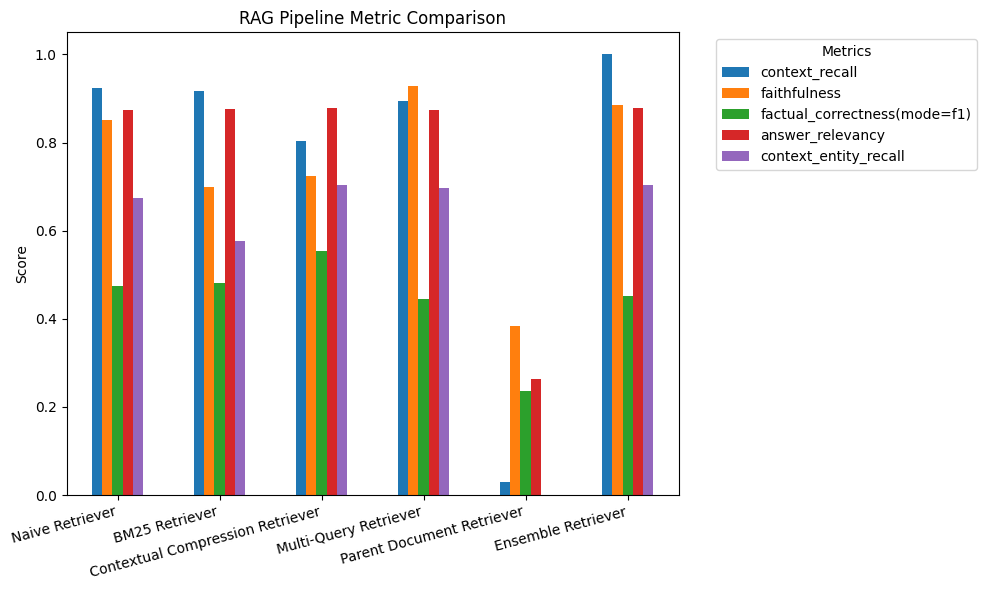

In [92]:
import matplotlib.pyplot as plt

# Plotting
ax = df.plot(kind='bar', figsize=(10, 6))

plt.title("RAG Pipeline Metric Comparison")
plt.ylabel("Score")
plt.xticks(rotation=15, ha='right')
plt.ylim(0, 1.05)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

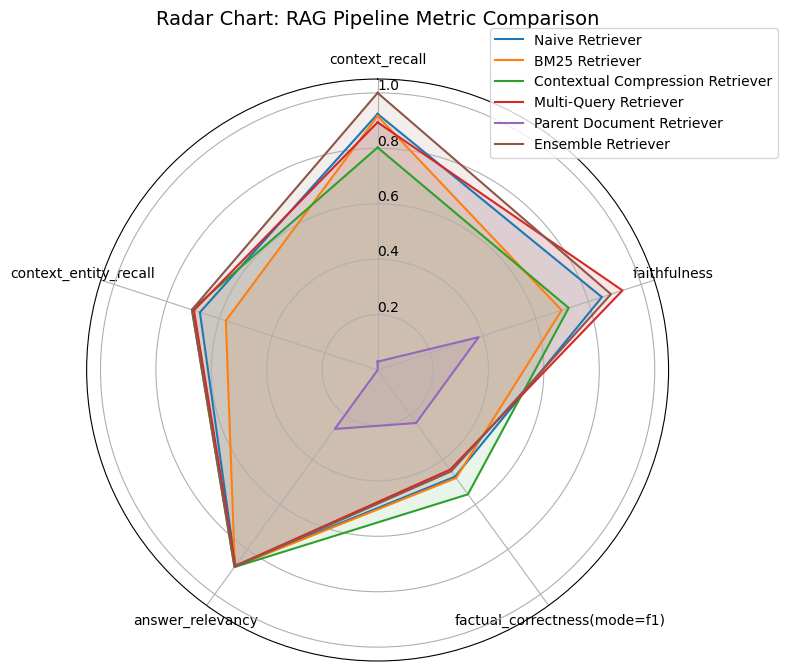

In [93]:
# Radar chart setup
labels = list(df.columns)
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

# Prepare figure
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each RAG method
for index, row in df.iterrows():
    values = row.tolist()
    values += values[:1]  # close the loop
    ax.plot(angles, values, label=index)
    ax.fill(angles, values, alpha=0.1)

# Configure chart
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set axis labels
ax.set_thetagrids(np.degrees(angles[:-1]), labels)

# Set range and grid
ax.set_ylim(0, 1.05)
ax.set_rlabel_position(0)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.title("Radar Chart: RAG Pipeline Metric Comparison", size=14, pad=20)

plt.tight_layout()
plt.show()

Based on this information, plus the latency and cost information present in LangSmith, the Contextual Compression Retriever seems to be the best option for the following reasons:

- **Factual Correctness**: This retriever offers the best factual correctness of all options, which is crucial in reliable information retrieval.
- **Cost efficiency**: At around 1200 tokens per query, this option is the second most cost-effective while still maintaining good performance.
- **Reasonable latency**: At around 0.34 seconds per query, this retriever's latency is one of the lowest. Balancing speed and performance, this retriever seems to be significantly better than the high-performing but slower options.
- **Strong entity recall**: With 0.70 entity recall, this retriever is among the highest at fetching context for specific entities.

Although the Ensemble Retriever achieves perfect context recall and better faithfulness than the Contextual Compression Retriever, its cost is more than 3 times higher and its latency more than 6 times higher than that of the Contextual Compression Retriever. Similarly, even though the Multi-Query Retriever has excellent faithfulness, its high cost and latency make it less practical. Meanwhile, the Contextual Compression Retriever excels particularly in factual correctness (often a critical metric for RAG systems), and in general, the Contextual Compression Retriever represents the best trade-off between quality and performance.